In [2]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw


In [3]:
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            
# model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/all_info_datasets/train_on_all_data_possible/only_1d_trial_2/")
model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/all_info_datasets/train_on_all_data_possible/only_hsqc_trial_2/")

hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"
checkpoint_path = model_path / "checkpoints/epoch=26-step=46278.ckpt"

with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
specific_radius_mfp_loader.setup(only_2d=False,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=False)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
model.change_ranker_for_testing()


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [4]:
# datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule = FolderDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC"], batch_size=1, parser_args=hparams)

In [12]:
# datamodule.setup("predict")

# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
#     datamodule.predict_dataloader()

datamodule.setup("test")
loader_only_hsqc = datamodule.test_dataloader()
    
model=model.to("cuda")

In [13]:
len(loader_only_hsqc.dataset)

3930

In [7]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))

smiles_and_names = [(index_to_smiles[file_index], index_to_chemical_names[file_index]) for file_index in sorted_file_indices]
len(smiles_and_names)


3930

In [8]:
len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

(3930, 3930, 3930)

In [9]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

In [10]:
all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [11]:
file_index = 10022
which_one = all_file_indices.index(file_index)
which_one

5

In [22]:
which_compound= which_one

In [23]:
loader_only_hsqc.dataset.files[which_compound], all_file_indices[which_compound]

('10022.pt', 10022)

In [29]:
filename = loader_only_hsqc.dataset.files[which_compound]

f_path = os.path.join(loader_only_hsqc.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename, f_path)

Chemspider_Pyristriatin A
COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
10022.pt /workspace/SMILES_dataset/test/oneD_NMR/10022.pt


In [30]:
hsqc

tensor([[ 1.5195999146e+02,  8.4174079895e+00,  7.0012636719e+03],
        [ 1.0703000641e+02,  6.3062500954e+00,  6.0723881836e+03],
        [ 9.0119995117e+01,  4.6437244415e+00,  6.2024873047e+03],
        [ 7.2059997559e+01,  4.3290147781e+00,  4.4014873047e+03],
        [ 6.5589996338e+01,  4.9892263412e+00, -1.9327648438e+04],
        [ 5.3930000305e+01,  3.4280686378e+00,  1.2197421875e+04],
        [ 4.7429996490e+01,  2.7613184452e+00,  6.9702373047e+03],
        [ 3.8220001221e+01,  3.0394577980e+00, -6.2024873047e+03],
        [ 3.8220001221e+01,  2.7769277096e+00, -7.8004257812e+03],
        [ 3.7560001373e+01,  1.5768891573e+00, -8.7660390625e+03],
        [ 3.7560001373e+01,  1.2707774639e+00, -5.1745043945e+03],
        [ 3.6869998932e+01,  1.5707473755e+00, -5.3333198242e+03],
        [ 3.6869998932e+01,  1.5074244738e+00, -4.7073588867e+03],
        [ 3.1759998322e+01,  2.0393445492e+00, -5.8693095703e+03],
        [ 3.1759998322e+01,  1.5518461466e+00, -4.6669291992e+

In [25]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C',
 'Chemspider_Pyristriatin A')

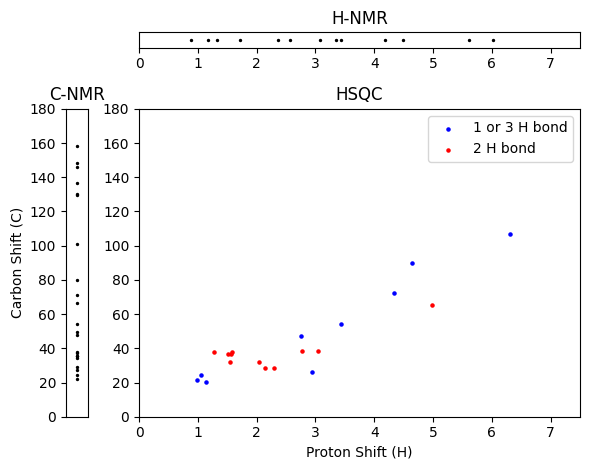

In [28]:
import matplotlib.pyplot as plt
# 
import matplotlib.gridspec as gridspec


# Create a 2x2 grid for subplots
fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

# Create subplots in different locations and sizes
pos = hsqc[hsqc[:,2]>0]
neg = hsqc[hsqc[:,2]<0]
ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
ax1.set_title("HSQC")
ax1.set_xlabel('Proton Shift (H)')  # X-axis label
ax1.set_xlim([0, 7.5])
ax1.set_ylim([0, 180])
ax1.legend()


ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
ax2.set_ylim([0, 180])
ax2.set_title("C-NMR")
ax2.set_ylabel('Carbon Shift (C)')
ax2.set_xticks([])

ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
ax3.set_xlim([0, 7.5])
ax3.set_title("H-NMR")
ax3.set_yticks([])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()



Chemical name 362572
Ground truth smiles COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1C(Cc1cc5c(c(c1)Oc1ccc(cc1)CC3N(C)CC2)OCO5)N(C)CC4


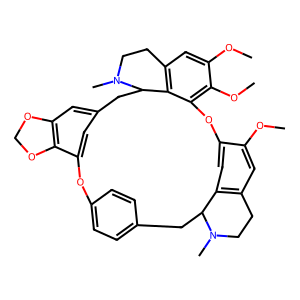

retival #1
HSQC smiles C=C1CCC2C(C)(C(=O)OC)CCCC2(C)C1CCC(C)CO
HSQC name 101675263


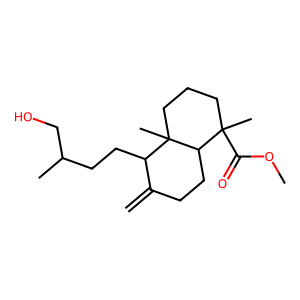

In [47]:
'''for a single model, show top-5'''

for  which_compound in [498]:  


    
    for idx, batch in enumerate(loader_only_hsqc):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        
        batch[0] = batch[0].to("cuda")
        topk_idx = model.predict_step(batch, idx, dataloader_idx=3)
        break
    
    # ground truth
    smiles, names = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    
    for topk in range(1):
        pred_smile, pred_name = smiles_and_names[topk_idx[topk][0]]
        mol = Chem.MolFromSmiles(pred_smile)
        print(f"retival #{topk+1}")
        print(f"HSQC smiles {pred_smile}")
        print(f"HSQC name {pred_name}")
        img = Draw.MolToImage(mol)
        img.show()
        


In [48]:
inputs

tensor([[[-1.0000000000e+00, -1.0000000000e+00, -1.0000000000e+00],
         [ 1.3110000610e+02,  7.1806883812e+00,  1.3785594727e+04],
         [ 1.2139999390e+02,  6.8849272728e+00,  1.1179619141e+04],
         [ 1.1965000153e+02,  5.9849991798e+00,  6.3457089844e+03],
         [ 1.1104999542e+02,  6.5250000954e+00,  4.0084287109e+03],
         [ 1.1030000305e+02,  5.4871244431e+00,  5.4274531250e+03],
         [ 1.0550999451e+02,  6.3947367668e+00,  4.2173032227e+03],
         [ 1.0155999756e+02,  6.3336253166e+00,  7.1013779297e+03],
         [ 1.0119999695e+02,  5.9292588234e+00, -1.2996642578e+04],
         [ 6.3569999695e+01,  3.8740282059e+00,  8.6133378906e+03],
         [ 6.1229999542e+01,  3.9949002266e+00,  6.2296528320e+03],
         [ 6.0279998779e+01,  3.1337780952e+00,  1.3457515625e+04],
         [ 5.5690002441e+01,  3.7597298622e+00,  1.4362541016e+04],
         [ 5.5599998474e+01,  3.5999999046e+00,  1.8688955078e+04],
         [ 4.5590000153e+01,  2.5699999332e+00, 

In [14]:
# pred_smile_HSQC, pred_name_HSQC, pred_smile_C, pred_name_C

In [15]:
# '''for a flexible model , show C vs HSQC'''
# occurence = 0
# for  which_compound in range(80):  


    
#     for idx, batch in enumerate(loader_only_hsqc):
#         if idx < which_compound:
#             continue
#         inputs, (smiles_chemical_name) = batch
        
#         batch[0] = batch[0].to("cuda")
#         topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#         break
#     pred_smile_HSQC, pred_name_HSQC = smiles_and_names[topk_idx_HSQC[0][0]]


#     for idx, batch in enumerate(loader_only_C_NMR):
#         if idx < which_compound:
#             continue
#         inputs, (smiles_chemical_name) = batch
        
#         batch[0] = batch[0].to("cuda")
#         topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#         # if idx <= 1: continue
#         break
#     pred_smile_C, pred_name_C = smiles_and_names[topk_idx_C_nmr[0][0]]
    
   


#     if pred_smile_C!=pred_smile_HSQC:
#         occurence+=1
#         print(f"Occurence {occurence}")
#         smiles, names = zip(*smiles_chemical_name)
#         mol = Chem.MolFromSmiles(smiles[0])
#         print(f"Ground truth smiles {smiles[0]}")
#         print(f"Chemical name {names[0]}")
#         img = Draw.MolToImage(mol)
#         img.show()
#         mol = Chem.MolFromSmiles(pred_smile_C)
#         print(f"C smiles {pred_smile_C}")
#         print(f"C name {pred_name_C}")
#         img = Draw.MolToImage(mol)
#         img.show()
#         mol = Chem.MolFromSmiles(pred_smile_HSQC)
#         print(f"HSQC smiles {pred_smile_HSQC}")
#         print(f"HSQC name {pred_name_HSQC}")
#         img = Draw.MolToImage(mol)
#         img.show()


In [16]:
len(topk_idx_HSQC[0])

NameError: name 'topk_idx_HSQC' is not defined

In [ ]:
'''demo all inputs'''
# for idx, batch in enumerate(loader_all_inputs):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_all_spec = model.predict_step(batch, idx, dataloader_idx=0)
#     # if idx <= 1: continue
#     break

'demo all inputs'

In [ ]:
'''demo C'''

# for idx, batch in enumerate(loader_only_C_NMR):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#     # if idx <= 1: continue
#     break

'demo C'

In [ ]:
'''demo hsqc'''

# for idx, batch in enumerate(loader_only_hsqc):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#     # if idx <= 1: continue
#     break

'demo hsqc'

In [ ]:
# """demo day: trying to show some results"""

# smiles, names = zip(*smiles_chemical_name)
# for i in range(len(smiles)):
#     print()
#     mol = Chem.MolFromSmiles(smiles[i])

#     # print("compound number", i+1)
#     print(f"Ground truth smiles {smiles[i]}")
#     print(f"Chemical name {names[i]}")
#     img = Draw.MolToImage(mol)
#     img.show()
    
#     for idx in range(2):
#         # pred_smile, pred_name = smiles_and_names[topk_idx_all_spec[idx][i]]
#         # print(f"Following is top-{idx+1} prediction using all three spectra: {pred_name}, smiles: {pred_smile}")
#         # mol = Chem.MolFromSmiles(pred_smile)
#         # img = Draw.MolToImage(mol)
#         # img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_C_nmr[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only C NMR: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         # pred_smile, pred_name = smiles_and_names[topk_idx_HSQC[idx][i]]
#         # print(f"Following is top-{idx+1} prediction using only HSQC: {pred_name}, smiles: {pred_smile}")
#         # mol = Chem.MolFromSmiles(pred_smile)
#         # img = Draw.MolToImage(mol)
#         # img.show()
        
#     print("===")

In [ ]:
# k = 5

# for idx, batch in enumerate(loader_all_inputs):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_all_spec = model.predict_step(batch, idx, dataloader_idx=0)
#     if idx <= k: continue
#     break

# for idx, batch in enumerate(loader_only_C_NMR):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#     if idx <= k: continue
#     break

# for idx, batch in enumerate(loader_only_hsqc):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#     if idx <= k: continue
#     break


# smiles, names = zip(*smiles_chemical_name)
# for i in range(len(smiles)):
#     print()
#     mol = Chem.MolFromSmiles(smiles[i])

#     print("compound number", i+1)
#     print(f"Ground truth smiles {smiles[i]}")
#     print(f"Chemical name {names[i]}")
#     img = Draw.MolToImage(mol)
#     img.show()
    
#     for idx in range(1):
#         pred_smile, pred_name = smiles_and_names[topk_idx_all_spec[idx][i]]
#         print(f"Following is top-{idx+1} prediction using all three spectra: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_C_nmr[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only C NMR: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_HSQC[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only HSQC: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#     print("===")